# COMP5331 Group 6 Project: Resilient k-Clustering

In [2]:
from os import mkdir
%load_ext autoreload
%autoreload 2

## Mount Drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/Comp 5331/"
%ls

## Preprocess datasets

In [1]:
from src.preprocess.process_uber import process_uber
ds_path = "dataset/uber/uber-raw-data-jun14.csv"
save_path = "dataset/uber/"
process_uber(ds_path, save_path)

11/08/2024, 13:20:35: creating graph
11/08/2024, 13:20:49: matching
11/08/2024, 13:20:54: finish


In [2]:
from src.preprocess.process_geo import process_geo
ds_names = ["Brightkite", "Gowalla"]
for ds_name in ds_names:
    print(f"Processing {ds_name} dataset")
    ds_path = f"dataset/snap_standford/{ds_name}_totalCheckins.txt"
    save_path = "dataset/snap_standford/"
    process_geo(ds_path, save_path, ds_name)

Processing Brightkite dataset
11/08/2024, 13:21:00: filtering
11/08/2024, 13:21:15: matching
11/08/2024, 13:21:15: finish
Processing Gowalla dataset
11/08/2024, 13:21:15: filtering
11/08/2024, 13:21:50: matching
11/08/2024, 13:21:50: finish


### Visualize the data

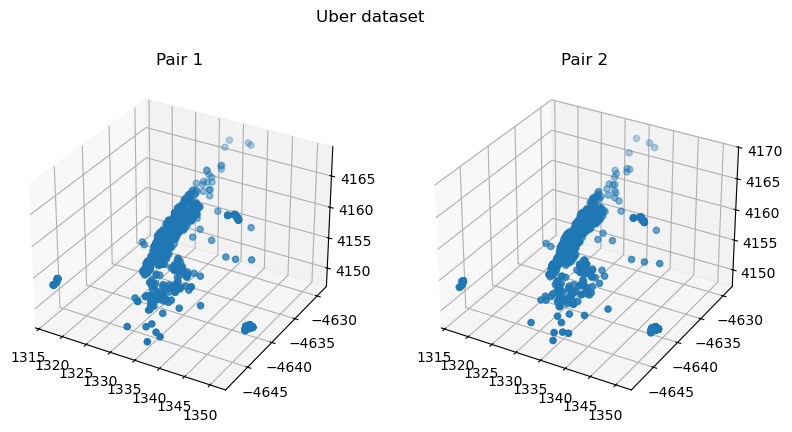

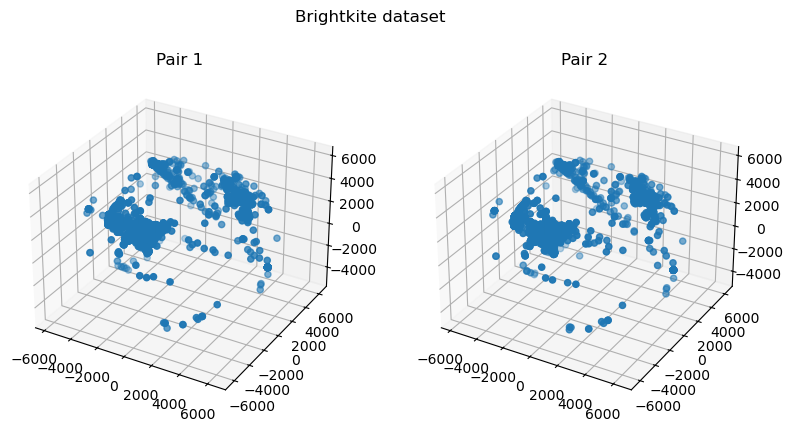

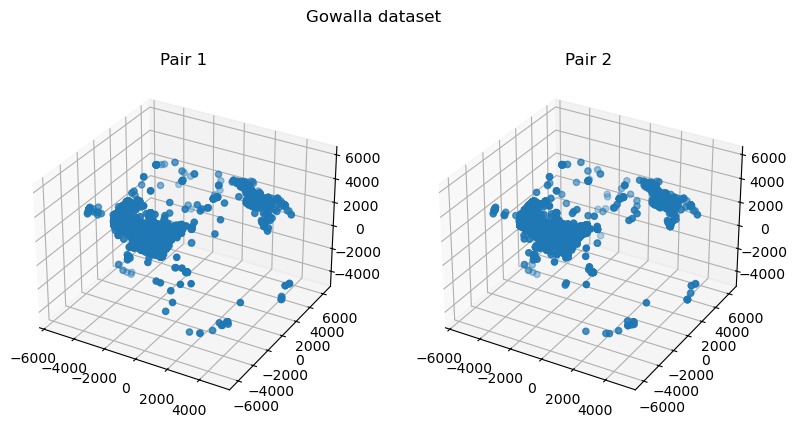

In [4]:
from src.testing.plot_helper import plot_data
from src.datasets import *
from os.path import join, isdir
from os import mkdir
ds_path = "./dataset"
dataset = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10), 
            Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50),
            Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50)]
plot_path = "./dataset/plot"
if not isdir(plot_path):
    mkdir(plot_path)
for ds in dataset:
    pair1, pair2 = ds.load()
    plot_data(pair1, pair2, plot_path, ds.name)

## Experiment

### k-resillient

In [5]:
import numpy as np
from src.resilient_k import resilient_k_center
from src.datasets import *
from os.path import join, isdir
from src.testing.plot_helper import plot_cluster_result
import pickle

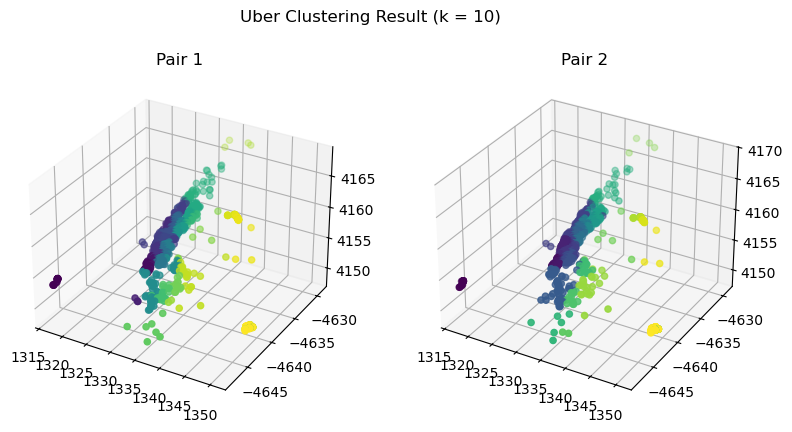

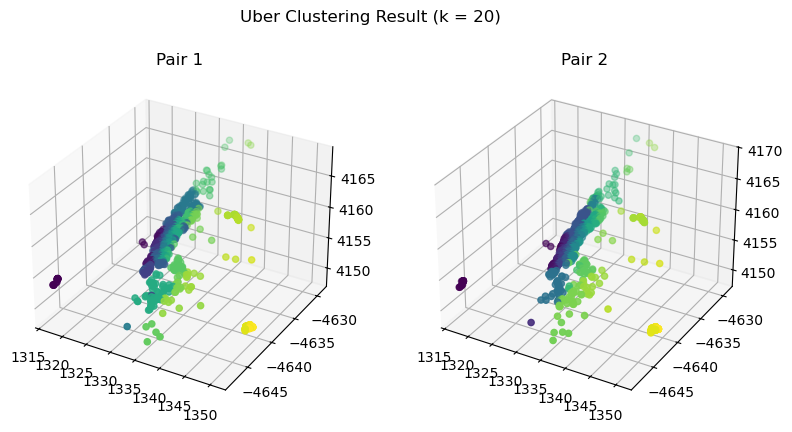

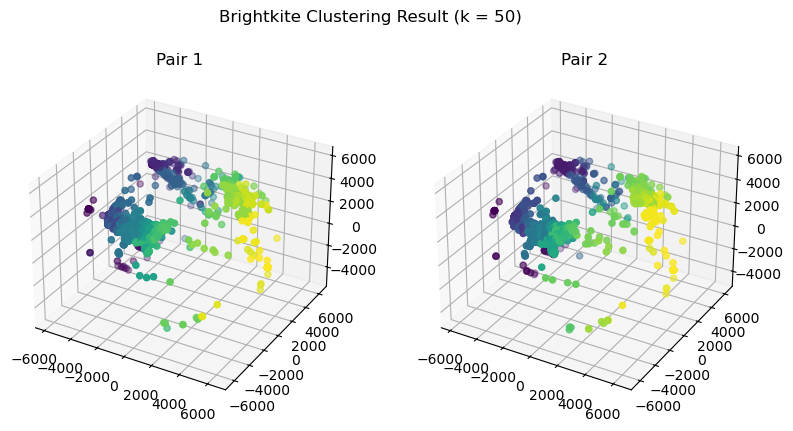

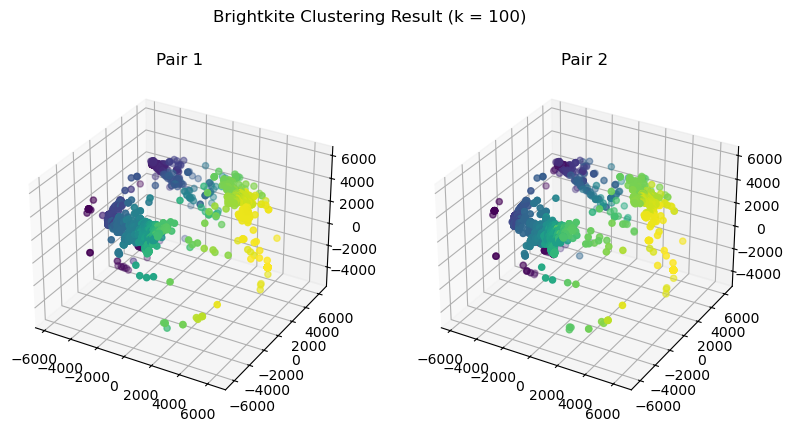

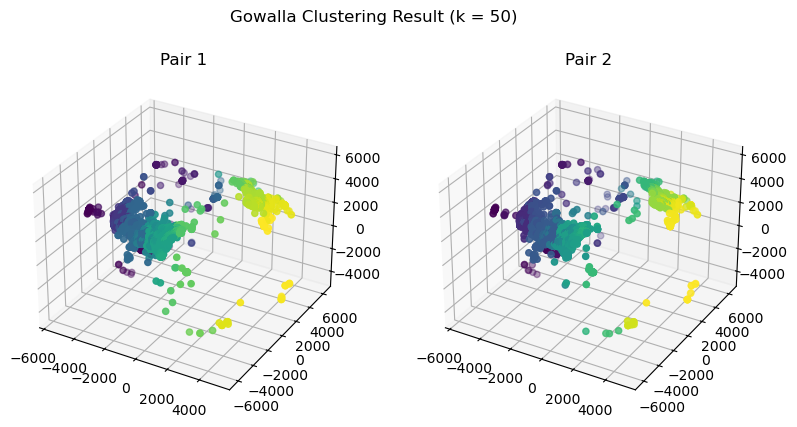

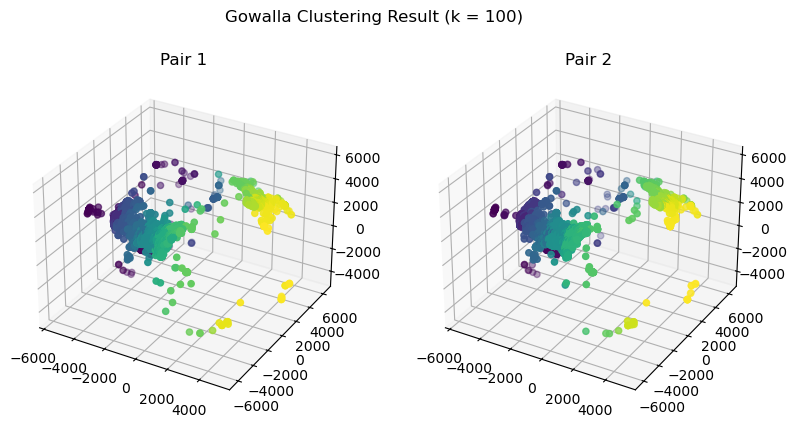

In [7]:
ds_path = "./dataset"
resilient_k_param ={"alpha": [0.5, 1.0], 
                    "beta": [0.5, 1.0], 
                    "algorithm": ["gonz", "carv"]}
dataset = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20),
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=100)]#,
           #Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           #Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=100)]
plot_path = "./results/plot"
result_path = "./results"

for ds in dataset:
    for algorithm in resilient_k_param["algorithm"]:
        for alpha in resilient_k_param["alpha"]:
            for beta in resilient_k_param["beta"]:     
                pair1, pair2 = ds.load()
                epsilon = 0.3
                model1 = resilient_k_center(pair1, k=ds.k, lamb=ds.lamb, epsilon=epsilon, alpha=alpha, beta=beta, algorithm=algorithm)
                center1, cluster1 = model1.resilient_k_center()
                model2 = resilient_k_center(pair2, k=ds.k, lamb=ds.lamb, epsilon=epsilon)
                center2, cluster2 = model2.resilient_k_center()
                
                with open(join(result_path, f"{ds.name}_resilient_{ds.k}_{algorithm}({alpha}_{beta}).pickle"), 'wb') as output_file:
                    pickle.dump((center1, cluster1, center2, cluster2), output_file)
                    
                pt1 = np.asarray([c[0] for c in cluster1])
                pt2 = np.asarray([c[0] for c in cluster2])
                label1 = [c[1] for c in cluster1]
                label2 = [c[1] for c in cluster2]
                plot_cluster_result(pt1, pt2, label1, label2, plot_path, ds, algorithm, alpha, beta)

## Evalutaion

In [66]:
from src.evaluation import Metrics
from src.testing.find_pair_assignment import find_pair_assign
from os.path import join, isdir
from os import mkdir

In [70]:
ds_path = "./dataset"
to_eval = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20),
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=100),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=100)]
result_path = "./results"
eval_path = join(result_path, "eval")
if not isdir(eval_path):
    mkdir(eval_path)
    
# for ds, ks in to_eval.items():
#     for k in ks:
for ds in to_eval: 
    pair1, pair2, label1, label2 = find_pair_assign(ds, result_path, eval_path)
    metric = Metrics()
    fraction_changed, sol_cost, num_cluster = metric.evaluate(old_points=pair1, old_medoids=label1, new_points=pair2, new_medoids=label2)
    print(f"-- {ds.name} (k = {ds.k}) --")
    print(f"fraction_changed = {fraction_changed}, sol_cost = {sol_cost}, num_cluster = {num_cluster}")

-- Uber (k = 10) --
fraction_changed = 0.0009174311926605505, sol_cost = 6371.000000000001, num_cluster = (34, 32)
-- Uber (k = 20) --
fraction_changed = 0.0009174311926605505, sol_cost = 6371.0, num_cluster = (65, 66)
-- Brightkite (k = 50) --
fraction_changed = 0.0004411116012351125, sol_cost = 6371.44436348453, num_cluster = (1, 1)
-- Brightkite (k = 100) --
fraction_changed = 0.0004411116012351125, sol_cost = 6371.44436348453, num_cluster = (1, 1)
-- Gowalla (k = 50) --
fraction_changed = 0.0001596169193934557, sol_cost = 6372.135043041732, num_cluster = (1, 2)
-- Gowalla (k = 100) --
fraction_changed = 0.0001596169193934557, sol_cost = 6372.135043041732, num_cluster = (1, 2)
